In [1]:
import timm
from fastai import *
from fastai.vision.all import *
import albumentations as A
import torchvision.transforms as transforms

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

d:\CN341\Basemodel\Resnetmodel\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_size =448
def get_train_aug(): return A.Compose([
            #AutoContrast(),
            #A.PadIfNeeded(always_apply=False, p=1.0, min_height=448, min_width=448, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            #A.HorizontalFlip(p=0.2),
            #A.ImageCompression(quality_lower=99, quality_upper=100),
            #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
            #A.Sharpen(always_apply=True, p=1.0, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
            #A.HueSaturationValue(
                #hue_shift_limit=0.3,
               # sat_shift_limit=0.3,
              #  val_shift_limit=0.3,
             #   p=0.5
            #),
            #A.RandomBrightnessContrast(p=0.2),
            A.Resize(image_size, image_size),
            #A.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
            #albumentations.ColorJitter(contrast=(0.9, 1.1)),
            #albumentations.CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
            #albumentations.RandomGamma(),
            #albumentations.ToGray(always_apply=False, p=1.0)

           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.)
def get_valid_aug(): return A.Compose([
            A.Resize(always_apply=False, p=1.0, height=image_size, width=image_size, interpolation=0),

            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
            #albumentations.ToGray(always_apply=False, p=1.0),
            #AutoContrast(),

            ], p=1.0)

In [3]:
train = pd.read_csv("D:\CN341\Basemodel\Resnetmodel\idrid-dataset/train.csv")

In [4]:
train = train[["image","class"]]
train["image_path"] = train["image"].map(lambda x: "D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/"+ str(x) +".jpg")

In [5]:
for i,p in enumerate(train["image_path"]):
  if not (os.path.exists(p)):
     train.loc[i,["image_path"]] = p[:-3] + "jpeg"
train["image"] = train["image_path"]
train = train[["image","class"]]

In [6]:
train

,image,class
0,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/aug_image_4_59_2.jpeg,4
1,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/aug_image_4_4_2.jpeg,4
2,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/94973b732f82.jpg,5
3,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/aug_image_1_271_1.jpeg,1
4,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/IDRiD_246.jpg,4
...,...,...
743,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/aug_image_4_14_0.jpeg,4
744,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/IDRiD_403.jpg,1
745,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/aug_image_4_377_1.jpeg,4
746,D:\CN341\Basemodel\Resnetmodel\idrid-dataset\Imagenes\Imagenes/IDRiD_117.jpg,2


In [7]:
len(train["image"].unique())

748

<BarContainer object of 6 artists>

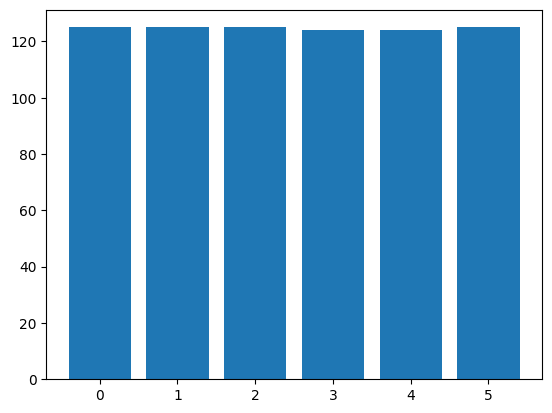

In [8]:
plt.bar([0,1,2,3,4,5],train["class"].value_counts(sort=False).sort_index())

In [9]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [10]:
item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [11]:
blocks = (ImageBlock, CategoryBlock)
splitter = TrainTestSplitter(0.01, stratify=train["class"],shuffle=True)
block = DataBlock(blocks = blocks,
                 get_x=ColReader(0),
                 get_y=ColReader(1),
                 splitter = splitter,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms)

dls = block.dataloaders(train, bs=4)

d:\CN341\Basemodel\Resnetmodel\.venv\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


In [12]:
early_stop= EarlyStoppingCallback(monitor='train_loss',patience=4)
callbacks = [
    early_stop,ShowGraphCallback()]

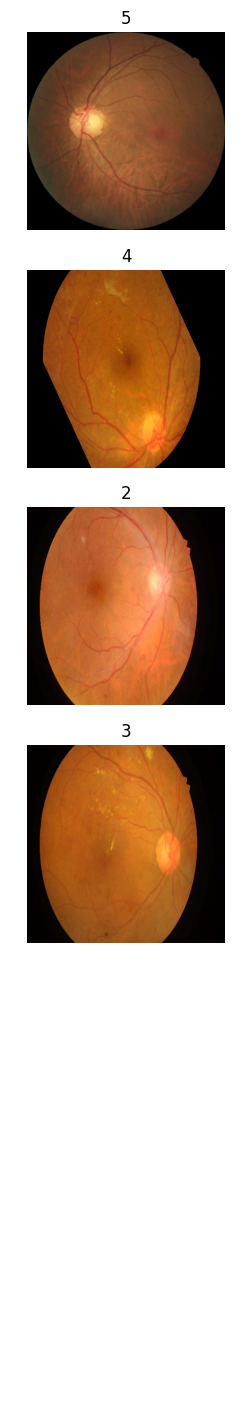

In [13]:
dls.show_batch(max_n=11,nrows=6,)

In [14]:
learner = vision_learner(dls,
                       'eva02_large_patch14_448',
                       loss_func=nn.CrossEntropyLoss(),
                       metrics=[accuracy],
                       )

learner.to_fp16()

In [15]:
learner.fine_tune(10,cbs=callbacks)

epoch,train_loss,valid_loss,accuracy,time


d:\CN341\Basemodel\Resnetmodel\.venv\lib\site-packages\timm\models\eva.py:126: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


KeyboardInterrupt: 